# Project Finding Donors for Charity ML

## Getting Started
In this project, I will employ several supervised algorithms of my choice to accurately model **_individuals' income_** using data collected from the 1994 U.S. Census. Afterwards, I will choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. My goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. 

This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. While it can be difficult to determine an individual's general income bracket directly from public sources, I can infer this value from other publically available features.

The data we investigate here consists of small changes to the original dataset, such as removing the 'fnlwgt' feature and records with missing or ill-formatted entries.

## Exploring the Data
Note that the last column from this dataset, 'income', will be the target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
#Importing necessary libraries 
import pandas as pd 
from time import time
import numpy as np

#import supplementary visualization code visuals.py
import visuals as vs

#Seeing graphs inline
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#Loading dataset
df = pd.read_csv('census.csv')
df.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Data Exploration
Investigating the dataset to determine how many individuals fit into either groups and showing the percentage of people making more than $50,000 a year. 

In [2]:
#Total number of records
n_records = len(df)

#Number of individuals making more than $50,000 anually 
n_greater_50k = len(df[df['income']=='>50K'])

#Number of individuals making at most 50k a year
n_at_most_50k = len(df[df['income']=='<=50K'])

#Percentage of individuals making more than 50k anually
greater_percent = n_greater_50k / n_records * 100 

print("Total number of records: {}".format(n_records))
print("Number of individuals making more than $50,000 annually: {}".format(n_greater_50k))
print("Number of individuals making at most $50,000 annually: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222
Number of individuals making more than $50,000 annually: 11208
Number of individuals making at most $50,000 annually: 34014
Percentage of individuals making more than $50,000: 24.78%


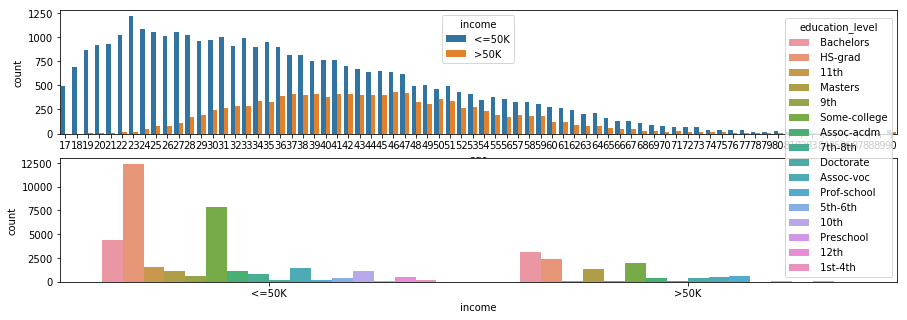

In [3]:
f,ax1 = plt.subplots(figsize=(15,5),nrows=2)
sns.countplot(x='age',hue='income',data=df,ax=ax1[0])
sns.countplot(x='income',hue='education_level',data=df,ax=ax1[1])

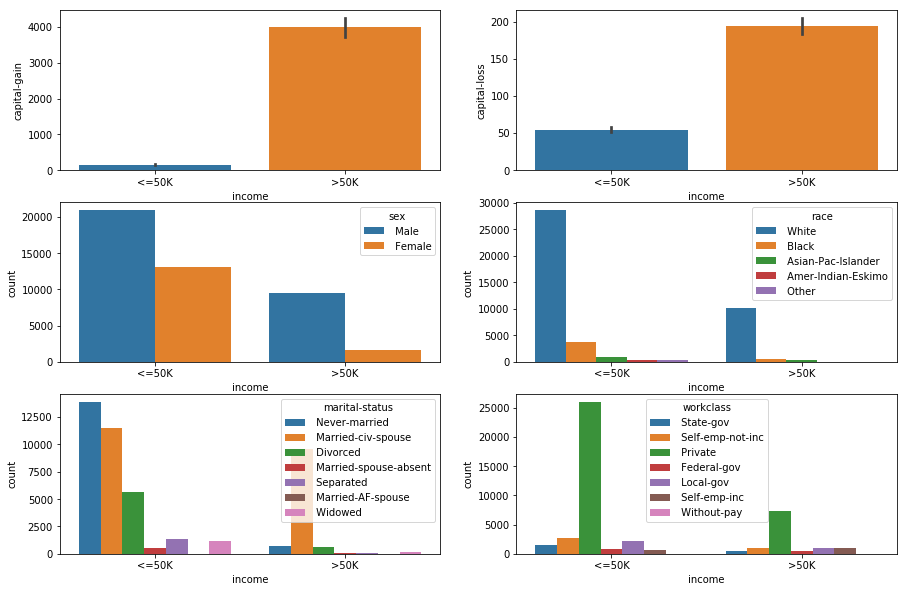

In [4]:
f,ax2 = plt.subplots(figsize=(15,10),ncols=2,nrows=3)
sns.barplot(x='income',y='capital-gain',data=df,ax=ax2[0][0])
sns.barplot(x='income',y='capital-loss',data=df,ax=ax2[0][1])
sns.countplot(x='income',hue='sex',data=df,ax=ax2[1][0])
sns.countplot(x='income',hue='race',data=df,ax=ax2[1][1])
sns.countplot(x='income',hue='marital-status',data=df,ax=ax2[2][0])
sns.countplot(x='income',hue='workclass',data=df,ax=ax2[2][1])

## Data Preprocessing
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **_preprocessing._**

Fortunately, for this dataset, there are no invalid or missing entries I have to deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. 

Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly **_normalized._** With the census dataset two features fit this description: 'capital-gain' and 'capital-loss'.

Looking at the below, note the range of the values present and how they are distributed.

In [9]:
#Creating a function to plot distributitions to visualise skewness
#before transformation and AFTER transformation

def distribution(data, transformed = False):
    """
    Visualization code for displaying skewed distributions of features
    """
    
    # Create figure
    fig = plt.figure(figsize = (11,5));

    # Skewed feature plotting
    for i, feature in enumerate(['capital-gain','capital-loss']):
        ax = fig.add_subplot(1, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        ax.set_ylim((0, 2000))
        ax.set_yticks([0, 500, 1000, 1500, 2000])
        ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

    # Plot aesthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Skewed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()

C:\Users\William X Nguyen\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


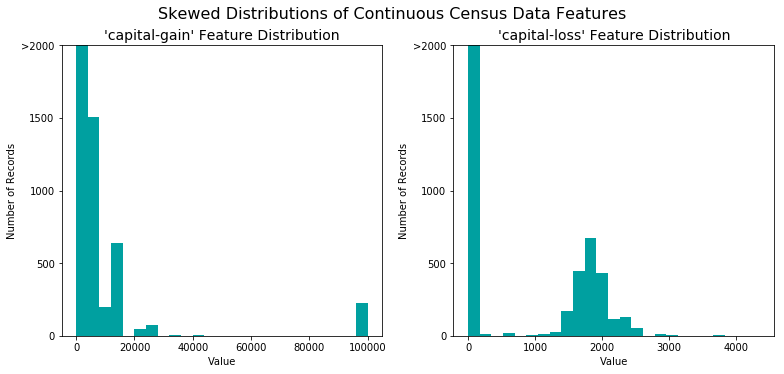

In [10]:
#Splitting data into features and target variable
income = df['income'] #Target variable
features = df.drop(['income'],axis=1)

#Visualising skewness continuous features of original data before
#any transformation has been done
distribution(features,transformed=False)

For highly-skewed feature distributions such as `capital-gain` and `capital-loss`, it is common practice to apply a **_logarithm transformation_** on the data so that very large and very small values don't negatively affect the performance of a learning algorithm.

Using a logarithm transformation significantly reduces the range of values caused by outliers. Care must be taken when applying logarithm transformation: The logarithm of `0` is undefined, so I might translate the values by a small amount ABOVE 0 to apply the logarithm successfully. 

C:\Users\William X Nguyen\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


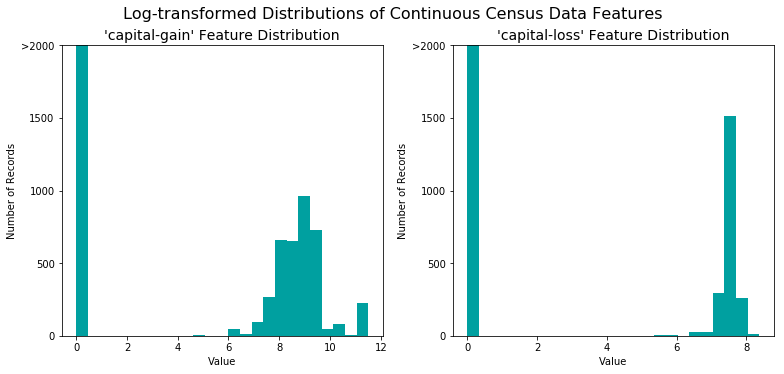

In [7]:
#Log-transformation of the skewed features
skewed = ['capital-gain','capital-loss']
features_log_transformed = pd.DataFrame(data=features)
features_log_transformed[skewed] = features[skewed].apply(lambda x: np.log(x+1))

#Visualising log distributions
distribution(features_log_transformed,transformed=True)


### Normalizing Numerical Features

In addition to performing **log transformations** on features that are highly skewed, it is often good practice to perform some type of _scaling on numerical features._ Applying a scaling to the data does not change the shape of each feature's distribution (such as 'capital-gain' or 'capital-loss' above); however, normalization ensures that each **_feature is treated equally when applying supervised learners._** 

**Note:** That once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

In [8]:
#Importing StandardScaler
from sklearn.preprocessing import MinMaxScaler

#Initalize a scaler and applying this scaler to numerical features
scaler = MinMaxScaler()
numerical_features = ['age','education-num','capital-gain',
             'capital-loss','hours-per-week']

#Creating data frame with log-transformed features
features_log_minmax_transform = pd.DataFrame(data=features_log_transformed)
features_log_minmax_transform[numerical_features].head()

,age,education-num,capital-gain,capital-loss,hours-per-week
0,39,13.0,7.684784,0.0,40.0
1,50,13.0,0.000000,0.0,13.0
2,38,9.0,0.000000,0.0,40.0
3,53,7.0,0.000000,0.0,40.0
4,28,13.0,0.000000,0.0,40.0


In [11]:
#Fitting the scaler to log-transformed numerical features
features_log_minmax_transform[numerical_features] = scaler.fit_transform(features_log_transformed[numerical_features])

In [12]:
#Looking at how scaling was applied 
features_log_minmax_transform[numerical_features].head(n=10)

,age,education-num,capital-gain,capital-loss,hours-per-week
0,0.301370,0.800000,0.667492,0.0,0.397959
1,0.452055,0.800000,0.000000,0.0,0.122449
2,0.287671,0.533333,0.000000,0.0,0.397959
3,0.493151,0.400000,0.000000,0.0,0.397959
4,0.150685,0.800000,0.000000,0.0,0.397959
5,0.273973,0.866667,0.000000,0.0,0.397959
6,0.438356,0.266667,0.000000,0.0,0.153061
7,0.479452,0.533333,0.000000,0.0,0.448980
8,0.191781,0.866667,0.829751,0.0,0.500000
9,0.342466,0.800000,0.742849,0.0,0.397959


In [13]:
#Looking at the whole dataset
features_log_minmax_transform.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Preprocessing 

There are several features that are non-numeric. Typically, algorithms expect input to be **numeric**, which requires that non-features features (_categorical variables_) to be converted. 

One way to convert categorical variables is by using the **one-hot encoding** scheme:
- One-Hot encoding creates a "_dummy_" variable for each possible category of each non-numeric feature. 
- For example, a feature `someFeature` has three possible unique values `A,B or C`. One-Hot encoding encodes this feature into `someFeature_A`, `someFeature_B`, `someFeature_C`

Additionally, along with the non-numeric independent variables, need to convert the non-numeric target variable, `income` to numerical values for the learning algorithms to work. 
- Since, there are only two values for this label ("<=50k" and ">50k"), I won't use one-hot encoding and simply encode these two categories as 0 and 1. 

In [15]:
#One-hot encoding the 'features_log_minmax_transform' data 
features_final = pd.get_dummies(features_log_minmax_transform)

#Encoding the target variable 'income' to numerical 0 and 1 values
income = income.apply(lambda x: 1 if x == ">50K" else 0)

#The number of columns after one-hot encoding 
encoded = (features_final.columns.tolist())
print("{} total features after one-hot encoding.".format(len(encoded)))

103 total features after one-hot encoding.


#### Splitting Data
Now that all categorical variables have been converted into numerical features, and all numerical features have been normalized -- the data for features and their labels are now split into training and test sets. 80% of the data will be used for training and 20% for testing. 

In [16]:
from sklearn.model_selection import train_test_split

#Splitting into train and testing set using X and y set (features and target)
X_train, X_test, y_train, y_test = train_test_split(features_final,
                                                   income, test_size=0.2,
                                                   random_state=0)

#Showing results of split 
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples".format(y_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples


## Evaluating Model Performance
I investigated different algorithms to determine which is best at modelling the data. Three of these algorithms will be supervised learners and the last algorithm will be a naive predictor. 

### Metrics and the Naive Predictor
I know that individuals that make more $50,000 are more likely to donate to charity. 

Thus, I'm interested in predicting **who** makes more than $50,000 accurately. Thus, I will use **accuracy** as a metric for evaluating the model's performance (more appropriate). 

**Note:** Identifying someone who doesn't make more than $50,000 as someone who does would be detrimental to the charity (penalty), as I'm looking for individuals who will donate. 

Thus, a model's ability to precisely predict those that make more than $50,000 is more _important_ than the model's ability to recall those individuals. I will use **F-beta score** as a metric that considers both precision and recall.

**Note:** Looking at the distribution of classes (those who make less than \$50,000 each year and those who make more), I can clearly see that most individuals do not make more than \$50,000 a year. 
- This can greatly affect **accuracy**, since I could say a person doesn't make more than $50,000 and generally be right without ever looking at the data.
- This is a **_naive_** statement, since I do not have any information to substantiate the claim. 
- Thus, it's important for me to consider the _naive prediction_ for my data. Why? **To help establish a benchmark for whether a model is performing well.**

### Metrics 
**Accuracy** measures _how often the classifier makes the correct prediction_. It is the ratio of the number of correct predictions to the total number of predictions (number of test data points). 

**Precision**. I don't know how to explain this well but I will explain this in terms of an example:
- Precision is the proportion of messages I classified (predicted) as spam, actually were spam. It is the ratio of true positives (classified as spam, and which are actually spam) to all positives (all words classified as spam, irrespective of whether that was the correct classification). 
- `True Positives/(True Positives + False Positives)`

**Recall (Sensitivity)**:
- Example: The proportion that actually were spam were classified by myself as spam. It is the ratio of true positives (words classified as spam, and which are actually spam) to all the words that were actually spam.
- `True Positives/(True Positives + False Negatives)`

### Important Notes
For classification problems that are skewed in the distributions like in this case, for e.g.:
- If I had 100 text messages and only 2 were spam and the rest 98 aren't, accuracy by itself is not very a good metric. 

I could classify 90 messages as not spam (including the 2 that were spam, but I classified them as not spam, hence they are false negatives) and 10 as spam (all 10 false positives) and still get a reasonably good accuracy score. 
- For such cases, precision and recall come in very handy. 
- These two metrics can combined to get the F1 score, which is the _weighted average (harmonic mean)_ of the precision and recall scores. 
- This score can range from 0 to 1, with 1 being the best possible F1 score. 

### Example Case: Naive Predictor Performance

If I had a model that always predicts '1' -- _always predicted an individual making more than \$50,000 (1), then my model will have no True Negatives (TN) or False Negatives (FN) as I'm not making any \$50,000 any negative ('0' value) predictions._ 
- Thus, the accuracy in this case becomes the same as the _Precision = True Positives/(True Positives + False Positives) as every prediction that I have made with value '1' that should have '0' becomes False Positive.
- The Recall Score (True Positives/(True Positives + False Negatives)) in this setting becomes 1 as I have no False Negatives. 

In [16]:
'''
#Counting the ones as this is the naive case
#"Income" column encoded to numerical values done in the pre-processing step
TP = np.sum(income)

FP = income.count() - TP #Specific to the naive case

TN = 0 #No predicted negatives in the naive case 
FN = 0 
'''

#If Income >50K --> income =1 ELSE --> income=0
TP = income.sum()
FP = len(income) - TP
TN = 0
FN = 0

#Calculate accuracy, precision and recall 
accuracy = TP/n_records 
recall = TP/(TP+FN)
precision = TP/(TP+FP)

#Calculating F-score using formula above for beta=0.5 and correct values for precision and recall
beta=0.5
fscore = (1+beta**2) * precision * recall/ ((beta**2 * precision) + recall)

#Print the results
print("The Naive Predictor: [Accuracy Score: {:.4f}, F-score: {:.4f}]".format(accuracy,fscore))

The Naive Predictor: [Accuracy Score: 0.2478, F-score: 0.2917]


## Supervised Learning Models 
**The following are some of the supervised learning models that are currently available in `scikit-learn`:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression 

### Model Application

#### Gaussian Naive Bayes 
A common area of application for Gaussian Naive Bayes is text classification. For example, if it can be used to classify emails as spam/non-spam. 

It could be a good candidate to solving the problem as the dataset has a lot of features after the one-hot encoding step -- **_Gaussian Naive Bayes is probably the fastest algorithm among the given ones_**.

**Strengths**:
- Gaussian Naive Bayes can deal with small training sets that have many features (e.g. text classification). 
The resulting model is very simple and can be trained _quickly_. It can deal well with datasets that have many features (high-dimensional datasets) due to its independence assumption. 

**Weaknesses**:
- Gaussian Naive Bayes does not work well if the training data are incomplete.
- Given the Naive-Bayes conditional independence assumption, when all the probabilities are multiplied together -- I will get 0.
- This will affect the posterior probability estimate. 
- Additionally, strongly correlating features might become an issue since Naive Bayes assumes independence of features. 
- It also cannot learn interactions between features (e.g. it can't learn that although I love specific action movies with Tom Cruise, it can't learn that I hate movies when there is Tom Cruise). 

#### Support Vector Machine 
SVM have a number of applications in several fields. Since the problem is a two-class problem, SVMs can be a good approach to solving this problem. By transforming into a higher dimensional space, I might be able to classify the data. 

**Strengths:**
- SVM can transform features in a higher dimensional space and finds a hyperplane in this space that separates the data points. 
- This the reason why SVM is able to solve problems that might not look linearly separable. 

**Weaknesses:**
- Fitting the model can take a long time depending on how you choose the _kernel parameters_. 
- Furthermore, picking the right kernel and its parameters is often _quite hard_. 
- In a way, the SVM moves the problem of overfitting from optimising the parameters to model selection. 
- More "complex" kernels (higher degree polynomials) are sensitive to overfitting. 
- Furthermore, SVM are binary classifiers. Solving a multi-class problem requires the training of multiple classifiers which takes a _long time_.

#### Gradient Boosting (Ensemble Method)
Ensemble learning methods helps improve machine learning results by combining several models. 
- Decision Tree based methods are fast to train. 
- However, a single decision tree is often not enough to classify the data accurately. 
- Combining multiple decision trees will improve the result (Random Forests, Gradient Boosting). 
- Since Gradient Boosting is superior to Random Forests (when picking the right parameters) most of the time, thus I will choose **Gradient Boosting.**

**Strengths:**
- GB-Trees have a better accuracy than Random Forests

**Weaknesses:**
- Prone to overfitting.
- Requires careful tuning of different hyper-parameters. 
- Regression: It might not be robust to outliers depending on the selected loss function (e.g. squared error). 

## Creating a Training and Predicting Pipeline

To properly evaluate the performance of each model, I've created a training and predicting test set to quickly and effectively train models.

## Implementation: Initial Model Evaluation
- Import three learning models 
- Initialize the 3 models and store them in 3 different variables 
- using random state for each model 
- calculate number of records equal to 1%, 10% and 100% of the training data. --> sample samples_1

In [48]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

# Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the models
clf_A = GaussianNB()
clf_B = SVC(random_state=0)
clf_C = GradientBoostingClassifier(random_state=0)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = len(y_train)//10
samples_1 = len(y_train)//100

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
        

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.


C:\Users\William X Nguyen\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\William X Nguyen\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


## Improving Results 
With the supervised learning models, to perform a grid search optimization for the model over the entire training set by tuning at least one parameter to improve upon the untuned model's F-score. 

### Choosing the Best Model
To choose a model, I will based this on:
- metrics - F-score on the testing set when 100% of the training data isused. 
- prediction/training time 
- the algorithm's suitability for the data

It seems that the best method to solve this problem is the **Gradient Boosting Classifier**. Besides the fact that the model achieves the best accuracy and f-score, it also can be trained in a reasonable amount of time. Thus, due to it's fast training, I will be able to fully utilize the entire dataset and therefore maximize performance on unseen data without parameter tuning. 

### Explaining Gradient Boosting 

Gradient boosting is an ensemble machine learning technique. Ensemble-based techniques combine many so-called "weak" learners into strong learners. A weak learner is any machine learning algorithm that performs poorly, its accuracy is above chance, but just barely. For example, a single decision tree with less depth (of course, in real-world I always have to consider a specific problem when before saying that an algorithm is weak).

**For example:** 
- I am given some training data I want to train the decision/regression tree classifier on. 
- I repeatedly ask questions like "Is the person older than 30?" until I am able to classify the feature successfully. 
- Unfortunately, asking a handful of questions is usually not enough to "win" such a question game (make an accurate prediction). 
- However, if I play the game more often and always ask different questions, then most likely increase the overall chance to win the game.

Anyway, there is still the question how to combine the different models. This is where the term "Gradient Boosting" comes into play. 
- Basically, Gradient Boosting tries to improve a bad overall result achieved by a set of decision/regression trees by producing a new tree that compensates the error made by the other models.
- In other words, I fit a regression tree and obtain a prediction for our training set. 
- Afterward, the difference is computed between the expected value and our prediction. This is the error made by our model. Then, training a new tree using the error as the new target value.

By repeating this process we finally generate a better and better model.

## Model Tuning 

Fine tuning the model by using the grid search with at least one important parameter tuned with at least 3 different values. 
- Import libraries
- Initiating classier 
- Create dictionary of parameters to tune for model 
        - parameters = {'parameter': [list of values]}
- Use make scorer to create fbeta score object with (beta=0.5)
- Perform grid search on classifier using the scorer and store it in an object
- fit grid search object to training data

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
"""
#Initialising classifier
model = GradientBoostingClassifier(random_state=0)

#Creating parameters list to tune using a dictionary
param_grid = {'max_depth': np.arange(2,10,2),
              'min_samples_leaf': [3,5,10],
              'n_estimators': [100,150,200]}


#Creating fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score,beta=0.5)

#Perform grid search on classifier using scorer as the scoring method 
grid = GridSearchCV(model,param_grid=param_grid,scoring=scorer,n_jobs=10,verbose=10)

#Fitting grid search object to training data and finding optimal parameters
grid_fit = grid.fit(X_train,y_train)

#Getting estimator 
best_model = grid_fit.best_estimator_

print("Best parameters: ",best_model)

#Making predictions 
predictions = model.fit(X_train,y_train).predict(X_test)
best_predictions = best_model.predict(X_test)

"""

## Feature Importance
An important task is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target variable -- I simplify the model. 

In this project, I wish to identify a small number of features that most strongly predict whether an individual makes at most or more than than \$50,000.

Thus, I chose **a sci-kit classifier** (e.g. adaboost, random forests) that has a **feature_importance_** attribute, which is a function that _ranks the importance of features according to the classifier_. 

### Extracting Feature Performance
Choosing a `sci-kit learn` supervised learning algorithm that has a `feature_importance_` attribute available to rank the importance of each feature when making predictions based on the algorithm chosen. 

In [26]:
#fitting this classifier to use attribute to determine most important features
model = GradientBoostingClassifier(random_state=0)
model.fit(X_train,y_train)

#Extracting features 
importances = model.feature_importances_

predictions = model.predict(X_test)

print(importances)

[0.11646978 0.09920928 0.13469614 0.12645531 0.07215414 0.01663593
 0.0093469  0.00063802 0.0080551  0.01679998 0.00108439 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00078882
 0.         0.00032652 0.00325507 0.00077654 0.         0.00877978
 0.12048277 0.00200985 0.00346957 0.         0.0004431  0.00103284
 0.         0.         0.03353741 0.02575067 0.01098044 0.00881954
 0.02371988 0.         0.02059776 0.00816304 0.01393628 0.01091407
 0.         0.01665547 0.00117322 0.00162452 0.00414705 0.
 0.02495729 0.         0.00083943 0.0019967  0.         0.00540884
 0.00664838 0.01404158 0.00237017 0.00476092 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00056198 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00114867 0.00092356 0.         0.00395553 0.         0.
 0.         0.         0.         0.00049466 0.         0.


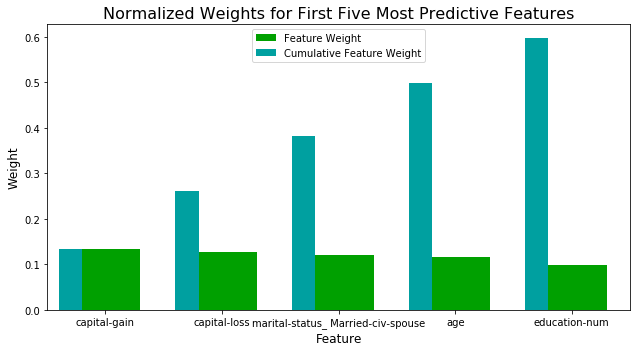

In [21]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    
    #Title
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    
    #Creating layout
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    
    #Inputting numbers
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, 
            align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    
    #Rewriting x,ylabels
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

feature_plot(importances,X_train,y_train)

Most top 5 important features contribute more than half of the importance of **all** features present in the data. Thus, by using the same optimized model I found earlier and train it on the training set with _only the top five important features.

In [1]:
# Import functionality for cloning a model
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(model)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))



NameError: name 'X_train' is not defined